In [352]:
import os

import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import shap

import config_local as cl
import ShapCalc


smag_path = os.path.join(cl.PREDICTIONS_PATH, 'SM_age_gender_to_ASCVD_no_perm','ascvd_percent_risk')
sm_path = os.path.join(cl.PREDICTIONS_PATH, 'SM_to_ASCVD_no_perm','ascvd_percent_risk')
dir = [sm_path, smag_path]

### Loading

Load all relevant files

In [353]:
risk_features = []
y_test = []
y_pred = []
x_test = []
metrics = []
model = []

data = []
data_test = []

explainer = []
shap_values = []
shap_df = []
abs_mean_shap_values = []
shap_imp = []

for i in range(len(dir)):
    risk_features.append(cl.load_pickle(os.path.join(dir[i],'risk_features.pickle')))
    y_test.append(cl.load_pickle(os.path.join(dir[i], 'y_test.pickle')))
    y_test[i] = y_test[i].rename(columns={'ascvd_percent_risk':'y_test'})
    y_pred.append(cl.load_pickle(os.path.join(dir[i], 'y_pred.pickle')))
    y_pred[i] = y_pred[i].rename(columns={'ascvd_percent_risk':'y_pred'})
    x_test.append(cl.load_pickle(os.path.join(dir[i], 'x_test.pickle')))
    metrics.append(cl.load_pickle(os.path.join(dir[i], 'results.pickle')))
    model.append(cl.load_pickle(os.path.join(dir[i], 'Model.pickle')))

    data.append(pd.concat([risk_features[i], y_pred[i]], axis=1))
    data_test.append(data[i][data[i]['y_pred'].notna()])
    data_test[i]['diff'] = data_test[i].ascvd_percent_risk - data_test[i].y_pred


    explainer.append(ShapCalc.shapExplainer(model[i]))
    shap_values.append(ShapCalc.shapValues(explainer[i], x_test[i]))
    shap_df.append(ShapCalc.shapDF(shap_values[i], x_test[i]))
    shap_df[i] = ShapCalc.column_abs_mean(shap_df[i])
    # shap_df.rename(y.columns[0])
    # indices.append(y.columns[0])
    shap_df[i] = pd.DataFrame(shap_df[i]).T
    abs_mean_shap_values.append(pd.DataFrame())
    abs_mean_shap_values[i] = abs_mean_shap_values[i].append(shap_df[i])
    shap_imp.append(ShapCalc.get_n_important_features(abs_mean_shap_values[i]))

    shap_df[i] = ShapCalc.shapDF(shap_values[i], x_test[i])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Plot SM or SM + Age + Gender

i == 0 is SM (sm)
i == 1 is SM + Age + Gender (smag)

In [273]:
i = 1

In [274]:

# data = pd.concat([risk_features[i], y_pred[i]], axis=1)
# data_test = data[data['y_pred'].notna()]
# data_test['diff'] = data_test.ascvd_percent_risk - data_test.y_pred


### Metrics

In [275]:

metrics[i]

,Coefficient_of_determination,explained_variance_score,pearson_r,pearson_p_value,spearman_r,spearman_p_value
ascvd_percent_risk,0.842857,0.842872,0.922215,0.0,0.906786,5.870177e-314


## Plotting of the results

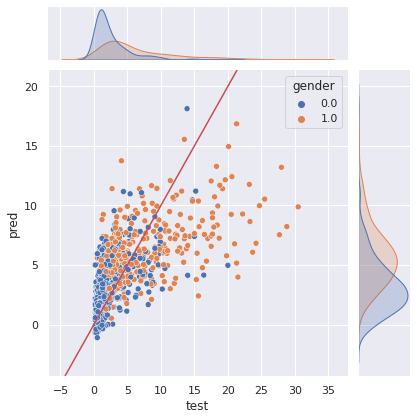

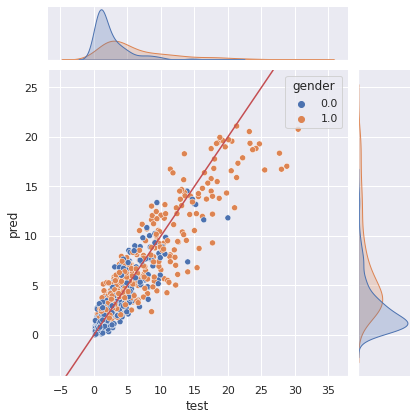

In [354]:
sns.set_theme()
for j in range(len(dir)):

    g = sns.jointplot(data = data_test[j], x='ascvd_percent_risk',y='y_pred',hue='gender')
    g.set_axis_labels('test', 'pred')
    g.ax_joint.axline([0,0],[1,1], color='r', label='Identity')

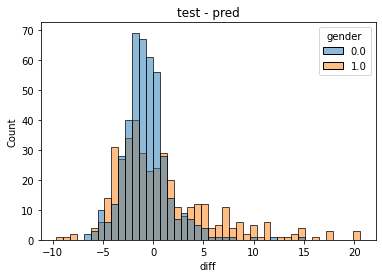

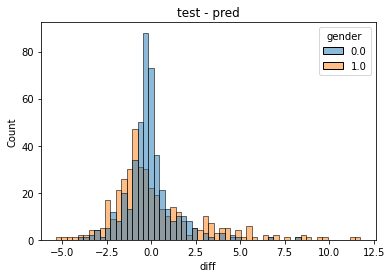

In [277]:
for j in range(len(dir)):

    h_diff = sns.histplot(data=data_test[j], x='diff', hue='gender')
    h_diff.set(title='test - pred')
    plt.show()

# SHAP

calculating the mean_abs shap values matrix, and taking the 5 most important ones

In [278]:
# explainer = ShapCalc.shapExplainer(model)
# shap_values = ShapCalc.shapValues(explainer, x_test)
# shap_df = ShapCalc.shapDF(shap_values, x_test)
# shap_df = ShapCalc.column_abs_mean(shap_df)
# # shap_df.rename(y.columns[0])
# # indices.append(y.columns[0])
# shap_df = pd.DataFrame(shap_df).T
# abs_mean_shap_values = pd.DataFrame()
# abs_mean_shap_values = abs_mean_shap_values.append(shap_df)
# shap_imp = ShapCalc.get_n_important_features(abs_mean_shap_values)


## Simple supervised clustering

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html?highlight=supervised#Simple-supervised-clustering

### PCA Reduction
Look at how many dimensions we want to reduce to

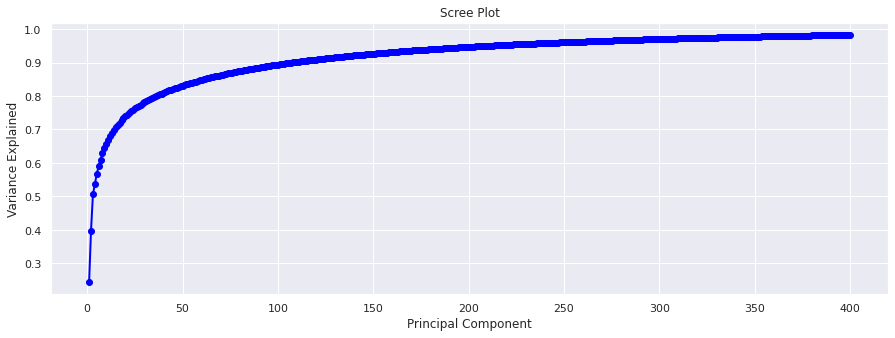

In [355]:
import matplotlib.pyplot as plt

clustering_data = shap_df[0]#.drop(columns=['gender','age'])

pca = PCA(n_components=400)
pca_fit = pca.fit(clustering_data)


PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

So it looks like we can take n_components=64

### Clustering
Clustering on the 64 dimensions pca with different clustering algorithms.
We chose 5 clusters

In [365]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE

n_components = 64
n_clusters = 8
clusters =[]
clusters.append(KMeans(n_clusters=n_clusters).fit(pca_fit.transform(clustering_data)[:, :n_components]))
clusters.append(SpectralClustering(n_clusters=n_clusters).fit(pca_fit.transform(clustering_data)[:, :n_components]))
tsne = TSNE(n_components=2).fit_transform((pca_fit.transform(clustering_data)[:, :n_components]))




The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


Plotting the different clusters

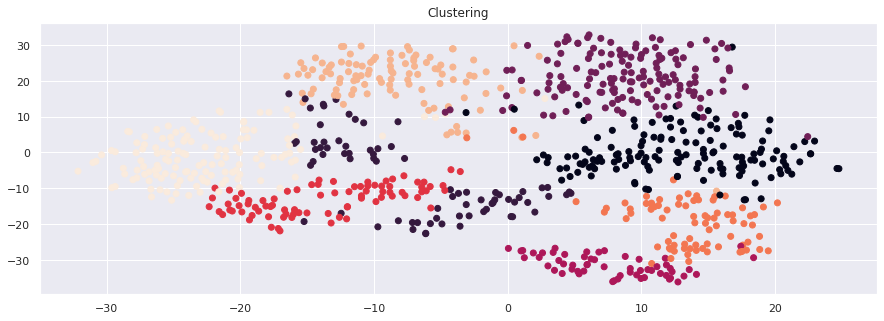

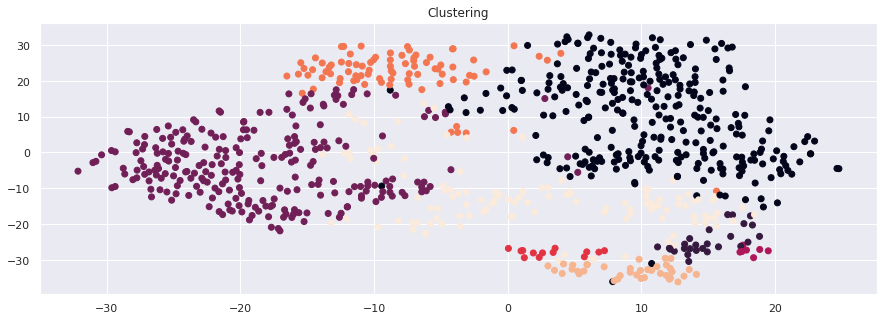

In [366]:
for i in range(len(clusters)):
    plt.scatter(tsne[:,0], tsne[:,1], c=clusters[i].labels_)
    plt.title('Clustering')
    plt.show()

In [282]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

shap_pca50 = PCA(n_components=12).fit_transform(shap_values[:1000,:])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000,:])

TypeError: list indices must be integers or slices, not tuple

In [ ]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

In [ ]:
f = plt.figure(figsize=(5,5))
plt.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_values[:1000,:].sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = plt.colorbar(label="Log odds of making > $50K", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
plt.gca().axis("off")
plt.show()

In [ ]:
for feature in shap_imp.columns.to_list():
    f = plt.figure(figsize=(5,5))
    plt.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=x_test[feature].values[:1000].astype(np.float64),
               linewidth=0, alpha=1., cmap=red_blue_solid)
    cb = plt.colorbar(label=feature, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    plt.gca().axis("off")
    plt.show()

### Dependence Plot

Plotting for the 5 most important features their dependence plot with their 2 most interactive features

In [ ]:

for name in shap_imp.columns.to_list():
    inds = shap.approximate_interactions(name, shap_values, x_test)
    for i in range(2):
        shap.dependence_plot(name, shap_values, x_test, interaction_index=inds[i])

In [ ]:
shap_imp.columns.to_list()
import umap

reducer = umap.UMAP()

# Adjusting for Age + Gender

In [ ]:
sns.heatmap(shap_df[1][shap_imp[1].columns.to_list()], robust='True', center=0)


In [284]:
shap_diff = shap_df[1].drop(columns=['gender','age']) - shap_df[0]
# shap_df.append(shap_df[1].drop(columns=['gender','age']))
# abs_mean_shap_values.append(pd.DataFrame())
# abs_mean_shap_values[2] = abs_mean_shap_values[2].append(shap_df[2])
# shap_imp.append(ShapCalc.get_n_important_features(abs_mean_shap_values[2]))
# shap_df[2]
# sns.histplot(shap_diff.mean(axis = 0))
shap_df[0]['ag'] = 0
shap_df[1]['ag'] = 1

cols = shap_imp[0].columns.to_list()
cols.append('ag')

shap_imp_merged_1 = pd.concat([shap_df[0][cols], shap_df[1][cols]], axis = 0)


cols = shap_imp[1].columns.to_list()
cols.append('ag')

shap_df[0][['age','gender']] = np.nan
shap_imp_merged_2 = pd.concat([shap_df[0][cols], shap_df[1][cols]], axis = 0, join='outer')
shap_imp_merged = pd.concat([shap_imp_merged_1, shap_imp_merged_2], axis=1)
shap_imp_merged.loc[:,~shap_imp_merged.columns.duplicated()].copy()

# shap_imp_merged = pd.concat([shap_imp_merged_1, shap_imp_merged_2], join='outer')
# shap_imp_merged

,Lipids_NEG_367.1583_42.5989_199.8372,Lipids_NEG_498.9296_99.7919_166.3289,Lipids_NEG_664.6242_396.8088_291.6015,Lipids_NEG_398.9360_63.8051_149.2762,Lipids_NEG_678.6395_404.2897_294.7948,ag,age,gender
10K_1851845680,1.226204,0.656477,0.434506,0.282334,0.182320,0,NaN,NaN
10K_5539624686,-0.002514,-0.562972,-0.028345,0.178242,-0.028056,0,NaN,NaN
10K_2192242203,-0.777026,0.196311,-0.151921,0.176973,-0.204006,0,NaN,NaN
10K_6158305978,0.431908,-0.366723,0.523409,0.327613,0.278359,0,NaN,NaN
10K_4787877293,-0.064431,0.541553,0.730190,0.283568,0.073423,0,NaN,NaN
...,...,...,...,...,...,...,...,...
10K_9536521206,-0.069116,-0.030999,0.182152,0.007029,-0.018667,1,-1.213443,-1.339918
10K_3675763080,0.383254,0.071715,0.281735,-0.003802,0.051280,1,5.404131,2.879769
10K_8589600935,-0.025812,-0.000005,-0.041384,0.013913,-0.003506,1,6.183753,2.458065
10K_8164227269,-0.084807,-0.118811,-0.160919,-0.061636,-0.018048,1,-2.112371,-1.023237


<AxesSubplot:xlabel='variable', ylabel='value'>

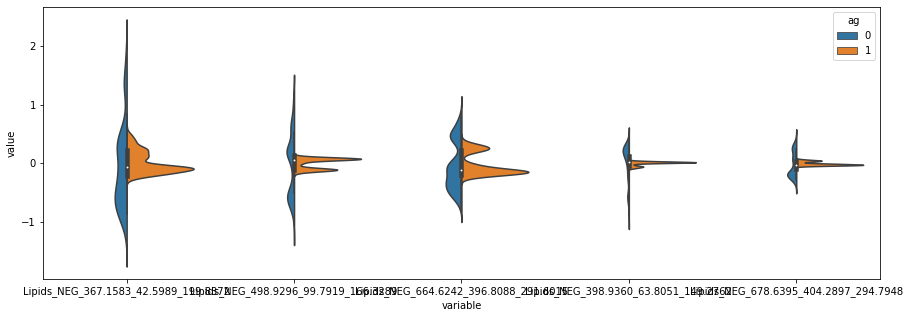

In [348]:
plt.rcParams['figure.figsize']=[15,5]
# cols = shap_imp[0].columns.to_list()
# melted = shap_imp_merged.drop(columns=['ag']).melt()
sns.violinplot(data=shap_imp_merged_1.melt(id_vars=['ag']), x='variable', y='value', hue='ag',split=True)
# shap_imp_merged_1.melt(id_vars=['ag'])

In [ ]:
shap_imp_merged_1.melt(id_vars=['ag']).variable.nunique()

In [332]:
print(shap_imp[0].columns)
shap_diff.drop(columns=['ag', 'age', 'gender']).mean().sort_values(ascending=False)

Index(['Lipids_NEG_367.1583_42.5989_199.8372',
       'Lipids_NEG_498.9296_99.7919_166.3289',
       'Lipids_NEG_664.6242_396.8088_291.6015',
       'Lipids_NEG_398.9360_63.8051_149.2762',
       'Lipids_NEG_678.6395_404.2897_294.7948'],
      dtype='object')


Lipids_NEG_367.1583_42.5989_199.8372     0.053419
Lipids_NEG_664.6242_396.8088_291.6015    0.021279
Lipids_NEG_678.6395_404.2897_294.7948    0.020047
Lipids_NEG_607.4208_305.1382_259.6633    0.014869
Lipids_NEG_498.9296_99.7919_166.3289     0.014070
                                           ...   
Lipids_POS_852.6809_380.6741_326.3672   -0.006336
Lipids_NEG_657.4970_291.5020_271.8989   -0.006364
Lipids_POS_756.8039_319.0163_294.0362   -0.008427
Lipids_NEG_398.9360_63.8051_149.2762    -0.008429
Lipids_NEG_812.5440_312.2824_308.7479   -0.008496
Length: 3698, dtype: float64

In [369]:
from LabData.DataLoaders.DEXALoader import DEXALoader

dxald = DEXALoader().get_data()

dxald.df[['total_scan_vat_mass', 'body_comp_total_fat_mass']]

[]


,,total_scan_vat_mass,body_comp_total_fat_mass
RegistrationCode,Date,,
10K_8047560215,2021-04-29,1466.514011,25371.060260
10K_8075904751,2021-04-20,95.428728,15504.454814
10K_8082666034,2021-04-27,1536.010423,33807.995999
10K_8095145724,2021-04-11,466.777722,33919.583240
10K_8096169656,2021-04-20,1113.054619,21636.555434
...,...,...,...
10K_9212152492,2022-05-03,1563.173578,36049.759958
10K_9273829991,2022-05-03,2021.313531,32335.131832
10K_9441031283,2022-05-02,1126.147808,23240.202649


# Adiopisity and Muscle Indices

In [370]:
adi_mus_ind = cl.load_pickle('/net/mraid08/export/genie/LabData/Analyses/galavner/Predictions/SM_to_RiskScores_Jupyter/all_results.pickle')

In [393]:
ind_name = adi_mus_ind[0][2].columns.to_list()
tmp_df=pd.DataFrame(pd.json_normalize(data=adi_mus_ind[0][6]))
tmp_df.index = ind_name
tmp_df
# pd.json_normalize(data=adi_mus_ind[0][6])

type(adi_mus_ind[0][1])

pandas.core.frame.DataFrame

In [480]:
import pandas as pd
adi_mus_metrics = pd.DataFrame()
adi_mus_y_test = pd.DataFrame()
adi_mus_y_pred = pd.DataFrame()
adi_mus_x_test = pd.DataFrame()
adi_mus_model = pd.DataFrame()

explainer_ind = []
shap_values_ind = []
shap_df_ind = []
abs_mean_shap_values_ind = []
shap_imp_ind = []
model_ind = []
x_test_ind = []
for i in range(len(adi_mus_ind)):
    ind_name = adi_mus_ind[i][2].columns.to_list()

    # temp_metrics = pd.DataFrame(pd.json_normalize(data=adi_mus_ind[0][6]), index=ind_name)
    # temp_metrics.index = ind_name
    # adi_mus_metrics = pd.concat([adi_mus_metrics,temp_metrics], axis=0)



    adi_mus_x_test = pd.concat([adi_mus_x_test, adi_mus_ind[i][1]], axis=0)
    adi_mus_y_test = pd.concat([adi_mus_y_test, adi_mus_ind[i][3]], axis=0)
    adi_mus_y_pred = pd.concat([adi_mus_y_pred, adi_mus_ind[i][4]], axis=0)
    model_ind.append( adi_mus_ind[i][5])

    x_test_ind.append(adi_mus_ind[i][1])

    explainer_ind.append(ShapCalc.shapExplainer(model_ind[i]))
    shap_values_ind.append(ShapCalc.shapValues(explainer_ind[i], x_test_ind[i]))
    shap_df_ind.append(ShapCalc.shapDF(shap_values_ind[i], x_test_ind[i]))
    shap_df_ind[i] = ShapCalc.column_abs_mean(shap_df_ind[i])
    # shap_df.rename(y.columns[0])
    # indices.append(y.columns[0])
    shap_df_ind[i] = pd.DataFrame(shap_df_ind[i]).T
    abs_mean_shap_values_ind.append(pd.DataFrame())
    abs_mean_shap_values_ind[i] = abs_mean_shap_values_ind[i].append(shap_df_ind[i])
    shap_imp_ind.append(ShapCalc.get_n_important_features(abs_mean_shap_values_ind[i]))

    shap_df_ind[i] = ShapCalc.shapDF(shap_values_ind[i], x_test_ind[i])


list

In [422]:
import LGBM
cols = []
tmp_metrics_df = pd.DataFrame()
for col in adi_mus_y_test.columns:
    tmp_metrics_ind = LGBM.evaluate_performance(adi_mus_y_pred[col].dropna(), adi_mus_y_test[col].dropna(), False)
    tmp_metrics_df = pd.concat([tmp_metrics_df, pd.json_normalize(tmp_metrics_ind)])
    cols.append(col)
    tmp_metrics_df.index = cols
tmp_metrics_df

,Coefficient_of_determination,explained_variance_score,pearson_r,pearson_p_value,spearman_r,spearman_p_value
visceral_fat_mass,0.576935,0.577532,0.763246,8.906067e-134,0.787817,3.226445e-148
visceral_fat_volume,0.596131,0.596625,0.773953,7.621201e-140,0.796274,1.218372e-153
visceral_fat_area,0.564142,0.564654,0.753304,2.005591e-128,0.779036,7.635415e-143
waist_to_hip_ratio,0.434801,0.438822,0.665806,3.277291e-90,0.696258,6.999337e-102
fat_mass_index,0.656588,0.657356,0.812686,1.820464e-164,0.818816,5.818704e-169
total_fat_percent,0.704130,0.705429,0.840409,2.874003e-186,0.849976,8.771313e-195
android_gynoid_ratio,0.572011,0.572984,0.761995,1.036527e-132,0.774524,8.859719e-140
trunk_to_limb_ratio,0.515793,0.519123,0.728547,8.215741e-116,0.752875,7.790028e-128
trunk_to_legs_ratio,0.534322,0.536724,0.733611,3.325607e-118,0.756114,1.528922e-129
lean_mass_index,0.485164,0.485210,0.698285,1.449414e-102,0.704454,3.963625e-105


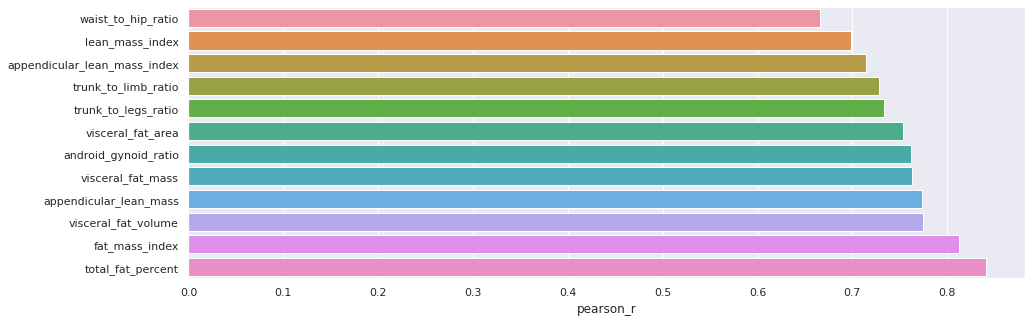

In [559]:
bp = sns.barplot(data = tmp_metrics_df.sort_values(by='pearson_r', axis=0),y=tmp_metrics_df.sort_values(by='pearson_r', axis=0).index, x='pearson_r')
plt.savefig(os.path.join(cl.PLOTS_PATH,'RiskScores',f'Pearson_r_BarPlot.png'), bbox_inches='tight')

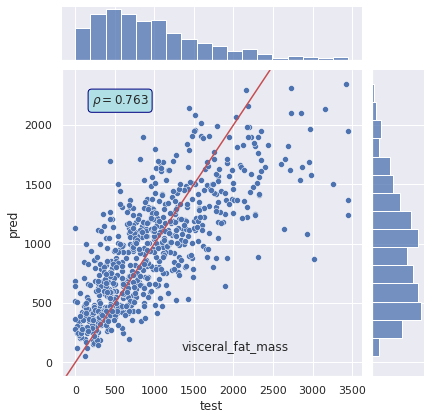

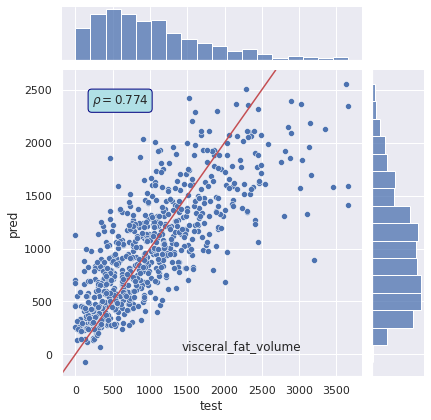

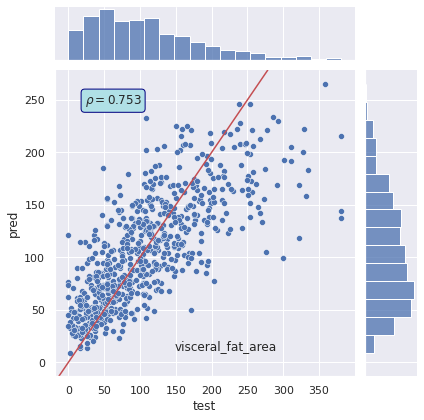

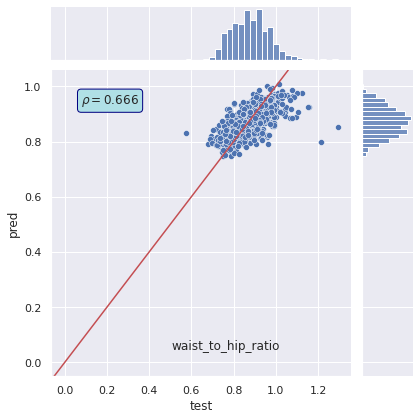

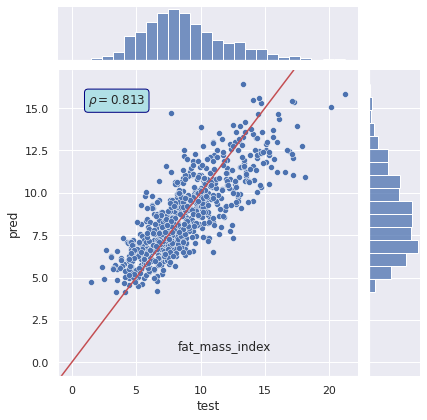

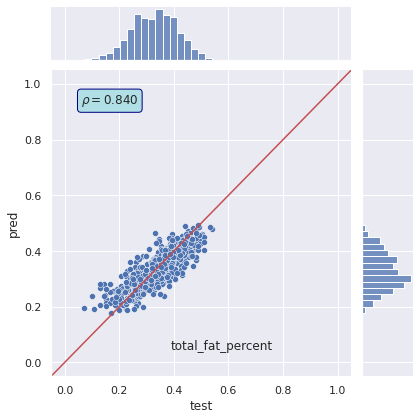

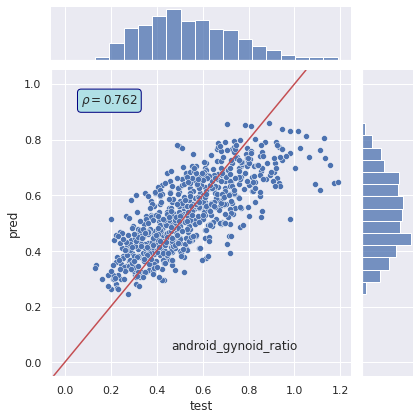

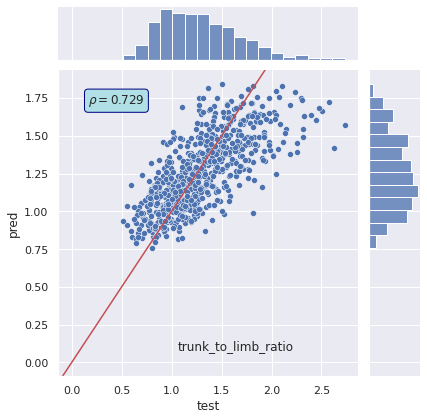

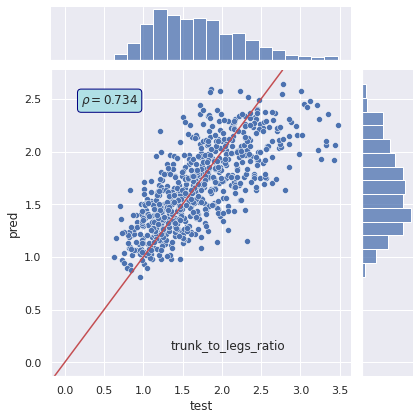

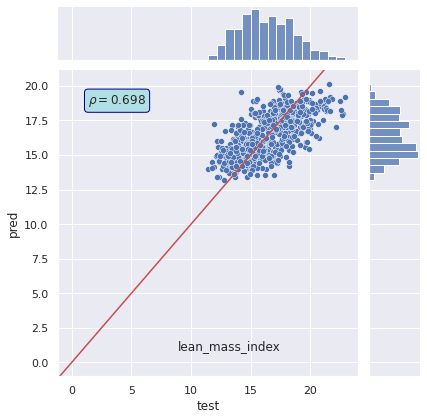

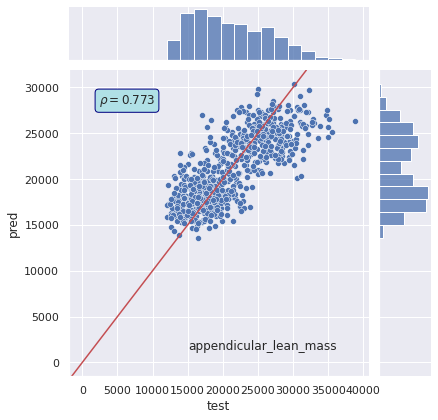

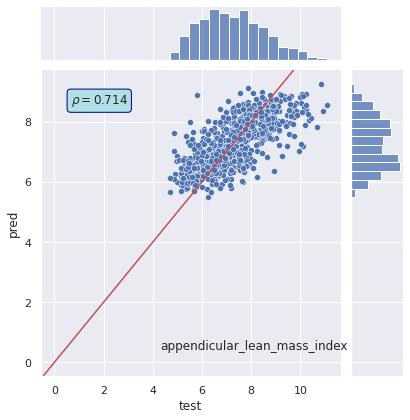

In [550]:
sns.set_theme()
# fig, axs = plt.subplots(4,3, figsize=(15,15))
# , ax=axs[i//4,i%3]
for i, col in enumerate(adi_mus_y_test.columns):

    g = sns.jointplot(x=adi_mus_y_test[col].dropna(),y=adi_mus_y_pred[col].dropna())
    g.set_axis_labels('test', 'pred')
    g.ax_joint.axline([0,0],[1,1], color='r', label='Identity')
    g.ax_joint.annotate(f'$\\rho = {tmp_metrics_df.loc[col].pearson_r:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
    g.ax_joint.annotate(col,
                    xy=(0.4, 0.1), xycoords='axes fraction',
                    ha='left', va='center')
    # plt.title(col, y=1)
    # g.set(title=col)
    # g.set_titles(col)
    # g.fig.tight_layout()
    g.savefig(os.path.join(cl.PLOTS_PATH,'RiskScores',f'{col}_ScatterPlot'))

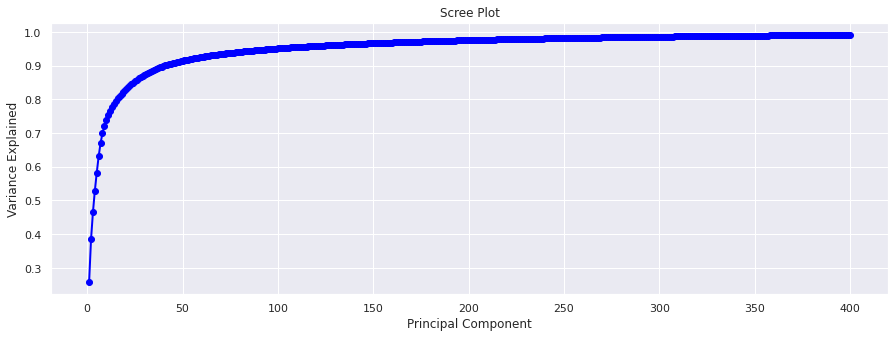

In [490]:
import matplotlib.pyplot as plt

clustering_data_ind = pd.concat(shap_df_ind)  #.drop(columns=['gender','age'])

pca_ind = PCA(n_components=400)
pca_fit_ind = pca.fit(clustering_data_ind)

PC_values_ind = np.arange(pca_fit_ind.n_components_) + 1
plt.plot(PC_values_ind, np.cumsum(pca_fit_ind.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Text(0, 0.5, 'Features')

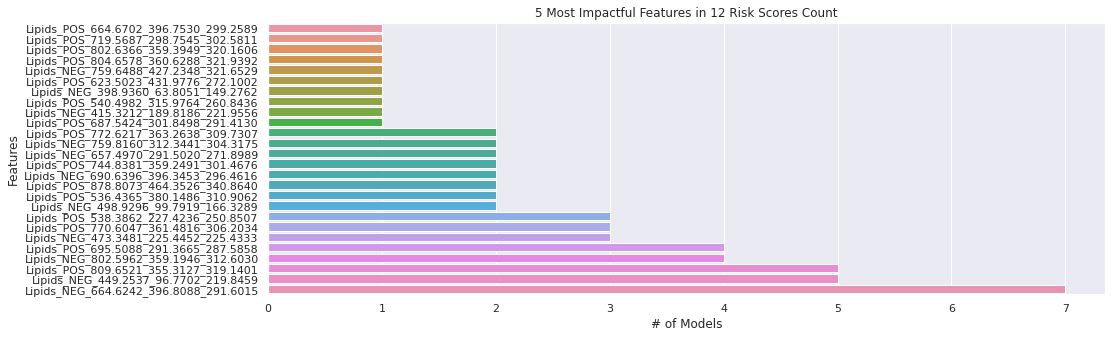

In [589]:
ShapCalc.get_most_important_frequency(shap_imp_ind[0])
# pd.concat(shap_imp_ind).count().sort_values(ascending=False)
sns.barplot(x = pd.concat(shap_imp_ind).count().sort_values().values, y=pd.concat(shap_imp_ind).count().sort_values().index)
plt.title('5 Most Impactful Features in 12 Risk Scores Count')
plt.xlabel('# of Models')
plt.ylabel('Features')
# pd.concat(shap_imp_ind).count()

In [560]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE

n_components_ind = 64
n_clusters_ind = 8
clusters_ind =[]
clusters_ind.append(KMeans(n_clusters=n_clusters_ind).fit(pca_fit_ind.transform(clustering_data_ind)[:, :n_components_ind]))
clusters_ind.append(SpectralClustering(n_clusters=n_clusters_ind).fit(pca_fit_ind.transform(clustering_data_ind)[:, :n_components_ind]))
tsne_ind = TSNE(n_components=2).fit_transform((pca_fit_ind.transform(clustering_data_ind)[:, :n_components_ind]))


Graph is not fully connected, spectral embedding may not work as expected.


KeyboardInterrupt: 

In [ ]:
for i in range(len(clusters_ind)):
    plt.scatter(tsne_ind[:,0], tsne_ind[:,1], c=clusters_ind[i].labels_)
    plt.title('Clustering')
    plt.show()

In [5]:
from os.path import join
import config_local as cl
smtoa = cl.load_pickle(join(cl.PREDICTION_RISK_SCORE_PATH, 'SerumMetabolomics', 'age','results.pickle'))
smtog = cl.load_pickle(join(cl.PREDICTION_RISK_SCORE_PATH, 'SerumMetabolomics', 'gender','results.pickle'))

In [27]:
from pandas import DataFrame

age_pred = DataFrame(smtoa.y_pred_lasso[0], index=smtoa.y_pred_lasso[0].index, columns=smtoa.y_pred_lasso[0].columns)
age_test = DataFrame(smtoa.y_test[0], index=smtoa.y_test[0].index, columns=smtoa.y_test[0].columns)

gender_pred = DataFrame(smtog.y_pred_tree[0], index=smtog.y_pred_tree[0].index, columns=smtog.y_pred_tree[0].columns)
gender_test = DataFrame(smtog.y_test[0], index=smtog.y_test[0].index, columns=smtog.y_test[0].columns)


Text(0.1, 0.9, '$\\rho = 0.690$')

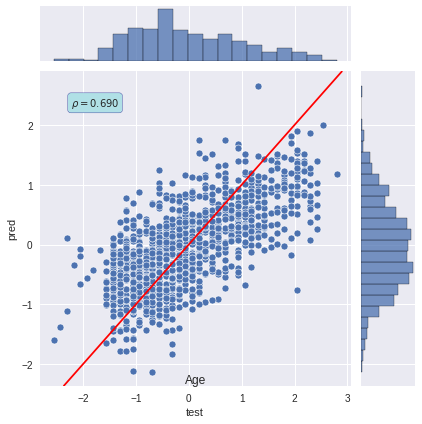

In [70]:
import seaborn as sns

g = sns.jointplot(x=age_test['age'], y=age_pred['age'])
g.set_axis_labels('test', 'pred')
g.ax_joint.set_title('Age', y=-0.01)
g.ax_joint.axline([0,0],[1,1], color='r', label='Identity')
g.ax_joint.annotate(f'$\\rho = {smtoa.metrics_lasso[0]["pearson_r"]:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

Text(0.5, 1.0, 'Gender')

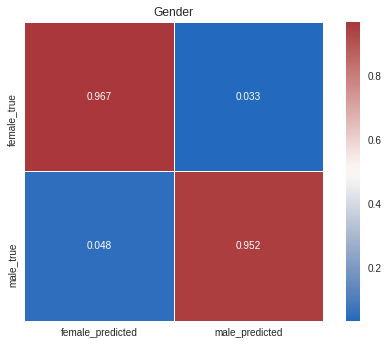

In [61]:
import pandas as pd
from sklearn.metrics import confusion_matrix
# sns.violinplot(x=gender_test['gender'], y=gender_pred['gender'])
# sns.heatmap(data=pd.concat([gender_test, gender_pred]))
conf = confusion_matrix(gender_test, gender_pred, normalize='true')
sns.heatmap(conf, annot=True, fmt = '.3f', square=1, linewidth=1., xticklabels=['female_predicted','male_predicted'], yticklabels=['female_true','male_true'], cmap="vlag")
plt.title('Gender')

In [78]:
smtog.metrics_tree[0]

{'prevalence': 0.4730593607305936,
 'AUC': 0.9594042544649131,
 'Precision_Recall': 0.9687295634828811}

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Gender')

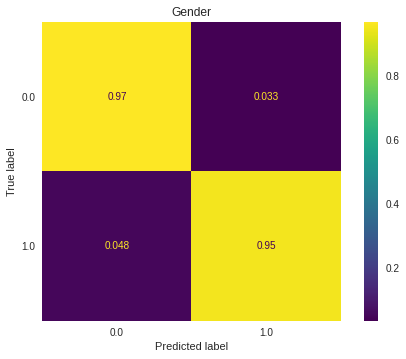

In [80]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(smtog.model_tree[0], smtog.x_test[0], smtog.y_test[0], normalize='true')
plt.grid(False)
plt.title('Gender')